In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import sys
import os
ISSM_DIR = os.getenv('ISSM_DIR') # for binaries

sys.path.append(ISSM_DIR + '/bin')
sys.path.append(ISSM_DIR + '/lib')
sys.path.append(ISSM_DIR + '/share')
sys.path.append(ISSM_DIR + '/share/proj')
sys.path.append(ISSM_DIR + '/src/m/contrib/defleurian/netCDF/')
sys.path.append('../source/')
sys.path.insert(0, '../scripts')

In [3]:
import numpy as np
import metavars
metavars.lake_name = 'MercerSubglacialLake'        # set to 'synth' or one of the lakes in the inventory
lake_name = metavars.lake_name
data_name = 'data_'+lake_name
from params import data_dir

In [4]:
# Load coordaintes to define ISSM mesh around the lake
x_f = np.load('../data/'+data_name+'/x_d.npy')*1e3
y_f = np.load('../data/'+data_name+'/y_d.npy')*1e3

## Mesh generation

OSGeo/GDAL for Python not installed, overlay plots are not enabled


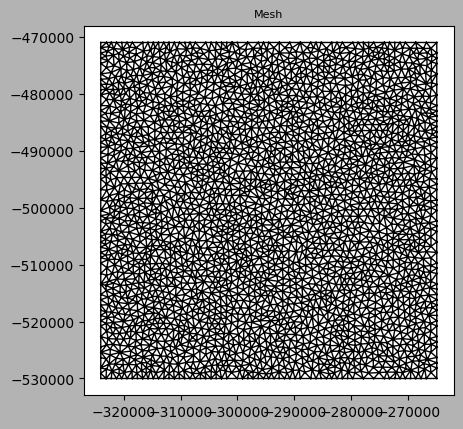

In [5]:
from triangle import triangle
from model import *
from netCDF4 import Dataset
from InterpFromGridToMesh import InterpFromGridToMesh
from InterpFromMeshToMesh2d import InterpFromMeshToMesh2d
from bamg import bamg
import matplotlib.pyplot as plt
from BamgTriangulate import BamgTriangulate
from plotmodel import plotmodel
from export_netCDF import export_netCDF
from setmask import setmask
from parameterize import parameterize
from setflowequation import setflowequation
from socket import gethostname
from solve import solve
from ll2xy import ll2xy

x_min = x_f.min()
x_max = x_f.max()
y_min = y_f.min()
y_max = y_f.max()

meshfile = data_dir+'/'+lake_name+'.exp'
fid = open(meshfile, 'w')

fid.write('## Name:{}\n'.format(lake_name))
fid.write('## Icon:0 \n')
fid.write('# Points Count  Value \n')
fid.write('5 1.000000 \n')
fid.write('# X pos Y pos \n')
fid.write('{:.0f} {:.0f}'.format(x_min,y_min)+' \n')
fid.write('{:.0f} {:.0f}'.format(x_max,y_min)+' \n')
fid.write('{:.0f} {:.0f}'.format(x_max,y_max)+' \n')
fid.write('{:.0f} {:.0f}'.format(x_min,y_max)+' \n')
fid.write('{:.0f} {:.0f}'.format(x_min,y_min)+' \n')
fid.close()

# Generate initial uniform mesh (resolution = 1000 m)
md = model()
md = triangle(model(), meshfile, 1000)
plotmodel(md, 'data', 'mesh')

## Interpolate ice flow speed onto the mesh and plot

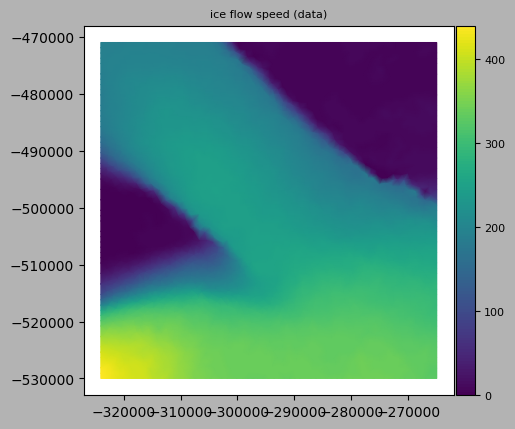

Anisotropic mesh adaptation

   new number of triangles = 4000


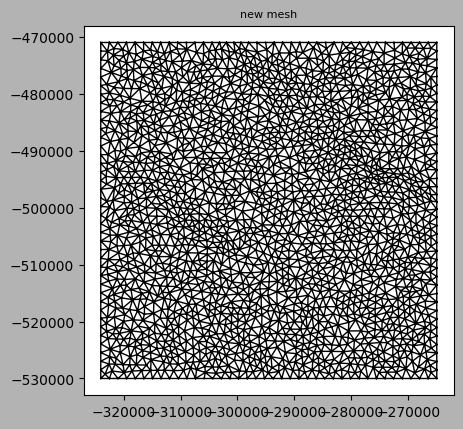

In [6]:
measures = Dataset('/Users/agstubbl/Desktop/measures/antarctic_ice_vel_phase_map_v01.nc')
u_m = np.flipud(measures['VX'][:].data)
v_m = np.flipud(measures['VY'][:].data)
speed = np.sqrt(u_m**2 + v_m**2)
x_m = measures['x'][:].data
y_m = np.flipud(measures['y'][:].data)
measures.close()

u = InterpFromGridToMesh(x_m, y_m, u_m, md.mesh.x, md.mesh.y, 0)
v = InterpFromGridToMesh(x_m, y_m, v_m, md.mesh.x, md.mesh.y, 0)
speed = np.sqrt(u**2 + v**2)

md.initialization.vel=speed
md.initialization.vx=u
md.initialization.vy=v

plotmodel(md,'data',md.initialization.vel,'title', 'ice flow speed (data)')
u_mean = u.mean()
v_mean = v.mean()

# Refine mesh according to flow speed
md = bamg(md, 'hmax', 1500, 'hmin', 50, 'gradation', 1.4, 'field', speed, 'err', 8)
plotmodel(md, 'data', 'mesh','title','new mesh')

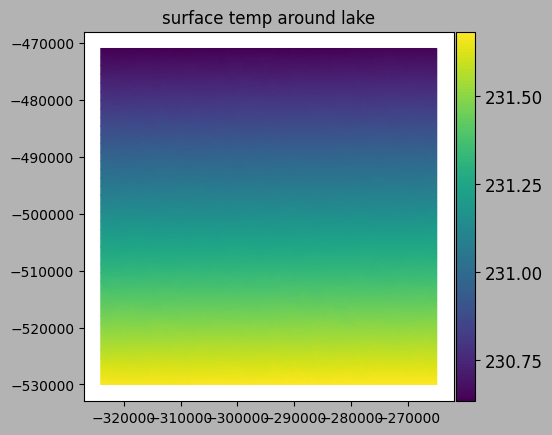

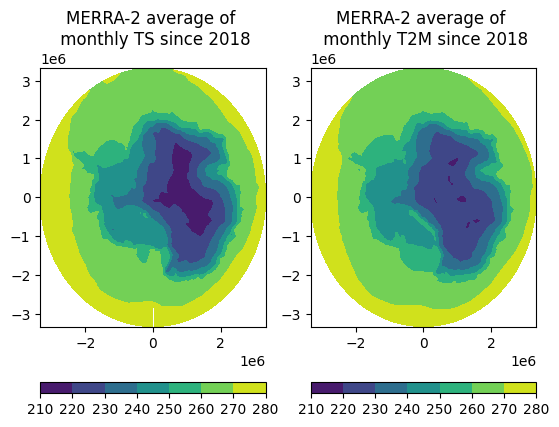

mean temperature = 252 K


In [7]:
# Get surface temperature from averaging monthly Merra-2 surface temperatures
# This is done in the parameterize file, but just checking that it works here ...
dir_str = '/Users/agstubbl/Desktop/merra2/'
directory = os.fsencode(dir_str)
filelist = []    
for file in os.listdir(directory):
    filename = os.fsdecode(file)
    if filename.endswith('.nc'): 
        filelist.append(filename)
        continue
    else:
        continue

num_months = len(filelist)

ds = Dataset(dir_str+filelist[0])
T_surf = np.zeros(np.shape(ds['TS'][:].data[0]))
T_2m = np.zeros(np.shape(ds['T2M'][:].data[0]))


for i in range(num_months):
    ds = Dataset(dir_str+filelist[i])
    T_surf += ds['TS'][:].data[0].astype(np.float64)/num_months
    T_2m += ds['T2M'][:].data[0].astype(np.float64)/num_months

    
lat = ds['lat'][:].data.astype(np.float64)
lon = ds['lon'][:].astype(np.float64)
llo,lla = np.meshgrid(lon,lat)
[xi, yi] = ll2xy(lla, llo, - 1, 0, 71)
x1 = xi.flatten()
y1 = yi.flatten()
T_ = T_surf.flatten()

T_ = T_[x1>0]
y1 = y1[x1>0]
x1 = x1[x1>0]

index = BamgTriangulate(x1, y1)
T_ = InterpFromMeshToMesh2d(index, x1, y1, T_, md.mesh.x, md.mesh.y)

plotmodel(md,'data', T_, 'title', 'surface temp around lake','fontsize',12)
# Plot MERRA-2 temperatures just FYI
plt.close()

plt.subplot(121)
plt.title('MERRA-2 average of \n monthly TS since 2018',fontsize=12)
plt.contourf(xi,yi,T_surf,levels=np.arange(210,281,10))
plt.colorbar(orientation='horizontal')

plt.subplot(122)
plt.title('MERRA-2 average of \n monthly T2M since 2018',fontsize=12)
plt.contourf(xi,yi,T_2m,levels=np.arange(210,281,10))
plt.colorbar(orientation='horizontal')
plt.show()

# set mean ice temperature to be (T_surf + T_base)/2
# where T_base is the melting point 
T_mean = 0.5*(T_.mean() + 273.15)
print('mean temperature = {:.0f} K'.format(T_mean))

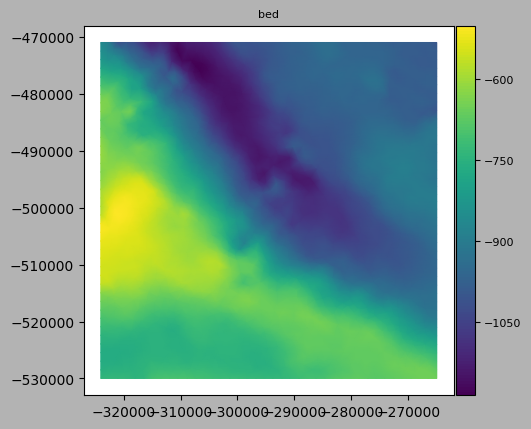

mean thickness = 1007 m


In [8]:
# Interpolate bedmachine thickness onto mesh and plot
bedmachine = Dataset('/Users/agstubbl/Desktop/bedmachine/BedMachineAntarctica-v3.nc')
x_bm = bedmachine['x'][:].data.astype(np.float64)
y_bm = np.flipud(bedmachine['y'][:].data.astype(np.float64))
H_bm = np.flipud(bedmachine['thickness'][:].data.astype(np.float64))
bed_bm = np.flipud(bedmachine['bed'][:].data.astype(np.float64))
md.geometry.base = InterpFromGridToMesh(x_bm, y_bm, bed_bm, md.mesh.x, md.mesh.y, 0)
md.geometry.thickness = InterpFromGridToMesh(x_bm, y_bm, H_bm, md.mesh.x, md.mesh.y, 0)

plotmodel(md,'data', md.geometry.base, 'title', 'bed')

H_mean = md.geometry.thickness.mean()
print('mean thickness = {:.0f} m'.format(H_mean))

In [9]:
md = setmask(md, '', '')
md = parameterize(md, '../scripts/ISSM_parameterize.py')
md = setflowequation(md, 'SSA', 'all')

      boundary conditions for stressbalance model: spc set as observed velocities
      no smb.mass_balance specified: values set as zero
      no basalforcings.groundedice_melting_rate specified: values set as zero
      no basalforcings.floatingice_melting_rate specified: values set as zero
      no dsl.global_average_thermosteric_sea_level specified: transient values set to zero
      no dsl.sea_surface_height_above_geoid specified: transient values set to zero
      no dsl.sea_water_pressure_at_sea_floor specified: transient values set to zero
      no balancethickness.thickening_rate specified: values set as zero


In [10]:
#Control general
md.inversion.iscontrol = 1
md.inversion.nsteps = 200
md.inversion.step_threshold = 0.99 * np.ones((md.inversion.nsteps))
md.inversion.maxiter_per_step = 10 * np.ones((md.inversion.nsteps))

#Cost functions
md.inversion.cost_functions = [101,103, 501]
md.inversion.cost_functions_coefficients = np.ones((md.mesh.numberofvertices, 3))
md.inversion.cost_functions_coefficients[:, 0] = 40
md.inversion.cost_functions_coefficients[:, 1] = 1
md.inversion.cost_functions_coefficients[:, 2] = 1e-6

#Controls
md.inversion.control_parameters = ['FrictionCoefficient']
md.inversion.gradient_scaling = 50 * np.ones((md.inversion.nsteps, 1))
md.inversion.min_parameters = 1 * np.ones((md.mesh.numberofvertices, 1))
md.inversion.max_parameters = 200 * np.ones((md.mesh.numberofvertices, 1))

#Additional parameters
md.stressbalance.restol = 0.01
md.stressbalance.reltol = 0.1
md.stressbalance.abstol = np.nan
md.stressbalance.loadingforce = np.zeros((md.mesh.numberofvertices, 3))

md.stressbalance.requested_outputs = ['default','DeviatoricStressxx', 'DeviatoricStressyy', 'DeviatoricStressxy']

#Go solve
md.cluster = generic('name', gethostname(), 'np', 2)
md.toolkits = toolkits()
md.verbose = verbose('solution', True, 'control', True)
md = solve(md, 'Stressbalance')

#Update model friction fields accordingly
md.friction.coefficient = md.results.StressbalanceSolution.FrictionCoefficient

export_netCDF(md, data_dir+"/Lake_control.nc")
!rm SquareLakes.bin SquareLakes.lock SquareLakes.queue SquareLakes.toolkits

checking model consistency
marshalling file 'SquareLakes'.bin
launching solution sequence

Ice-sheet and Sea-level System Model (ISSM) version  4.24
(website: http://issm.jpl.nasa.gov forum: https://issm.ess.uci.edu/forum/)

call computational core:
   preparing initial solution

       x       |  Cost function f(x)  |  List of contributions
====================== step 1/200 ===============================
 x =         0 |    computing velocities
   computing adjoint
   saving results
f(x) =      28.2005  |      0.3573413     27.84316 1.191162e-32
 x =         1 | f(x) =     27.75108  |       0.299932     27.43778   0.01336828
====================== step 2/200 ===============================
 x =         0 |    computing velocities
   computing adjoint
   saving results
f(x) =     27.88863  |      0.2982939     27.57696   0.01336828
 x =         1 | f(x) =     26.50077  |      0.2475443     26.21093   0.04229926
====================== step 3/200 ===============================
 x =    

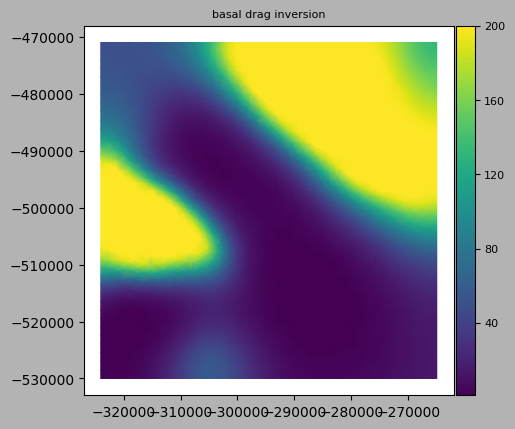

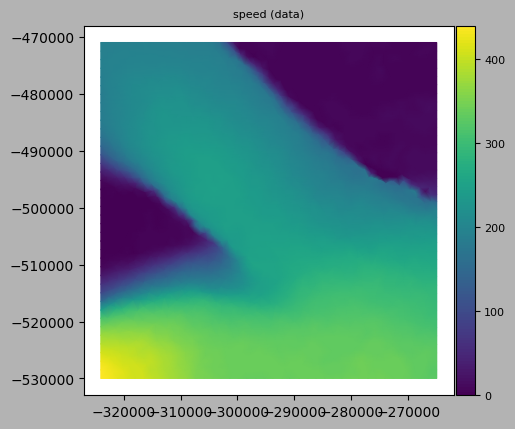

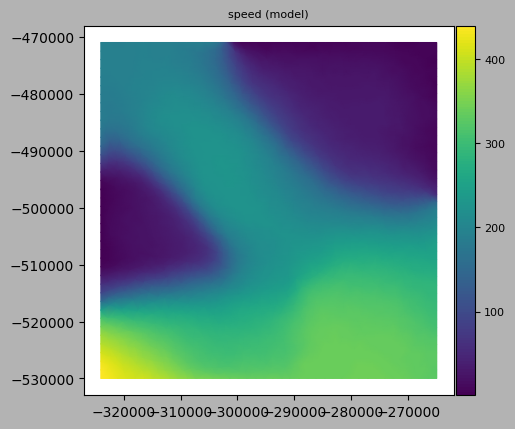

In [11]:
plotmodel(md,'data', md.friction.coefficient, 'title', 'basal drag inversion')
plotmodel(md,'data', md.inversion.vel_obs, 'title', 'speed (data)')
plotmodel(md,'data', md.results.StressbalanceSolution.Vel, 'title', 'speed (model)')

In [12]:
beta_mean = (md.friction.coefficient*3.154e7).mean()
print('mean drag = {:.2e} Pa s/m'.format(beta_mean))

mean drag = 2.63e+09 Pa s/m


Calculate the (depth-averaged) viscosity:

mean viscosity = 6.08e+14 Pa s


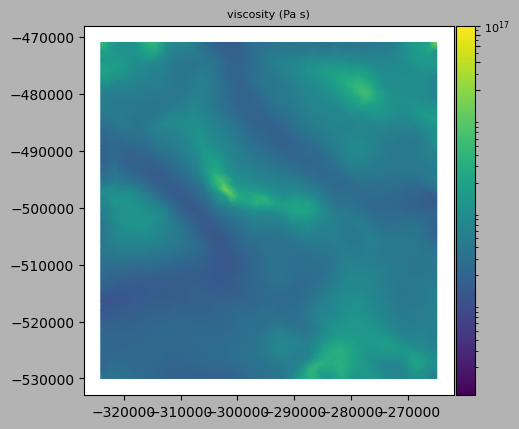

In [13]:
tau_xx = md.results.StressbalanceSolution.DeviatoricStressxx
tau_xy = md.results.StressbalanceSolution.DeviatoricStressxy
tau_yy = md.results.StressbalanceSolution.DeviatoricStressyy
tau_E = np.sqrt(tau_xx**2 + 2*tau_xy**2 + tau_yy**2)/np.sqrt(2)

n = md.materials.rheology_n.mean()
B = md.materials.rheology_B.mean()
eta = 0.5*(B**n) * tau_E**(1-n)
eta_mean = eta.mean()

print('mean viscosity = {:.2e} Pa s'.format(eta_mean))
plotmodel(md,'data', eta, 'title', 'viscosity (Pa s)','caxis', [1e13 ,1e17],'log',10)

In [14]:
# Save all of the auxiliary parameter spatial means from ISSM 
np.save('../data/'+data_name+'/eta.npy',np.array([eta_mean]))    # viscosity: Pa s
np.save('../data/'+data_name+'/beta.npy',np.array([beta_mean]))  # basal drag: Pa s / m
np.save('../data/'+data_name+'/H.npy',np.array([H_mean]))        # thickness: m
np.save('../data/'+data_name+'/u.npy',np.array([u_mean]))        # vel x: m/yr
np.save('../data/'+data_name+'/v.npy',np.array([v_mean]))        # vel y: m/yr
np.save('../data/'+data_name+'/x.npy',(x_f-x_f.mean())/H_mean)   # x coord (shifted & scaled by ice thickness)
np.save('../data/'+data_name+'/y.npy',(y_f-y_f.mean())/H_mean)   # y coord (shifted & scaled by ice thickness)